<a href="https://colab.research.google.com/github/Bedadeepa/DeepLearning/blob/main/transfer_learning_MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 29th Jan, 2023
# https://www.tensorflow.org/tutorials/images/transfer_learning

Objectives
> Examine and understand the data<br>
> Build an input pipeline, in this case using Keras ImageDataGenerator<br>
>>Compose the model<br>
>>Load in the pretrained base model (and pretrained weights)<br>
>Stack the classification layers on top<br>
>Train the model<br>
>Evaluate model<br>


Note: It appears in this model, learning rate plays a very crucial role. Further, whenever you change any model-compilation parameters, start from %reset point. Deleteing model, re-initializing etc do not appear to help.

## Install software

In [ ]:
# 1.0 Install current tensorflow
!pip install tensorflow==2.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 61.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 KB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 3.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully uninstalled tensorflow-estimator-2.11.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.11.2
    Uninstalling tensorboard-2.11.2:
      Successf

## Call libraries

In [ ]:
# 1.1
#%reset
import numpy as np
import pandas as pd

# 1.1.1
import matplotlib.pyplot as plt

# 1.1.2
import tensorflow as tf

# 1.1.3
import PIL
import pathlib,os

In [ ]:
# 1.1.4 Verify version:
tf.__version__

'2.10.0'

In [ ]:
# 1.1.5
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Download data

In [ ]:
# 2.0 Data URL:

data_url = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

In [ ]:
# 2.1 Delete any existing data

!rm -rf /root/.keras/datasets

In [ ]:
# 2.2 Download now:

data_dir = tf.keras.utils.get_file(origin = data_url, extract= True)
data_dir

68606236/68606236 [==============================] - 5s 0us/step


'/root/.keras/datasets/cats_and_dogs_filtered.zip'

In [ ]:
# 2.3 Check data files:

!ls -la /root/.keras/datasets

total 67012
drwxr-xr-x 3 root root     4096 Mar  1 07:59 .
drwxr-xr-x 1 root root     4096 Mar  1 07:59 ..
drwxr-xr-x 4 root root     4096 Mar  1 07:59 cats_and_dogs_filtered
-rw-r--r-- 1 root root 68606236 Mar  1 07:59 cats_and_dogs_filtered.zip


In [ ]:
# 2.3.1 Check data files:

!ls /root/.keras/datasets/cats_and_dogs_filtered

train  validation  vectorize.py


In [ ]:
# 2.3.2
!cat /root/.keras/datasets/cats_and_dogs_filtered/vectorize.py

from keras.preprocessing.image import array_to_img, img_to_array, load_img

import os

for fname in os.listdir('train/cats'):
  print fname


## Examine data

In [ ]:
# 2.3.2

data_dir = pathlib.Path("/root/.keras/datasets/cats_and_dogs_filtered")

In [ ]:
# 2.3. ToDo
data_dir.chmod(777)

In [ ]:
!ls -la /root/.keras/datasets

total 67012
drwxr-xr-x 3 root root     4096 Mar  1 07:59 .
drwxr-xr-x 1 root root     4096 Mar  1 07:59 ..
dr----x--t 4 root root     4096 Mar  1 07:59 cats_and_dogs_filtered
-rw-r--r-- 1 root root 68606236 Mar  1 07:59 cats_and_dogs_filtered.zip


In [ ]:
# 2.3.3 Iterate over data_dir: 

for i in data_dir.iterdir():
  print(i)

/root/.keras/datasets/cats_and_dogs_filtered/validation
/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/vectorize.py


In [ ]:
a = data_dir / "train"

In [ ]:
type(a)

pathlib.PosixPath

In [ ]:
# 2.3.4 Check within train:

for j in (a).iterdir():
  print(j)

/root/.keras/datasets/cats_and_dogs_filtered/train/cats
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs


<Figure size 720x720 with 0 Axes>

<AxesSubplot:>

(-0.5, 248.5, 269.5, -0.5)

<AxesSubplot:>

(-0.5, 417.5, 291.5, -0.5)

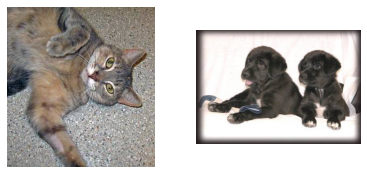

In [ ]:
# 3.0 Plot images:

plt.figure(figsize = (10,10))
for k,i in enumerate((data_dir / "train").iterdir()):
  for j in i.iterdir():
    im = PIL.Image.open(j)
    im = np.asarray(im)
    plt.subplot(3,3,k+1)
    plt.imshow(im)
    plt.axis("off")
    break;

## train/test/validation generators

In [ ]:
# 3.1 Some constants:

batch_size = 32
image_size = (160,160)

In [ ]:
# 3.2 Create train data generator

train_ds = tf.keras.utils.image_dataset_from_directory(data_dir / "train",
                                                       shuffle = True,
                                                       batch_size = batch_size,
                                                       image_size=image_size,
                                                       )

Found 2000 files belonging to 2 classes.


In [ ]:
# 3.2.a Create train data generator

train_ds = tf.keras.utils.image_dataset_from_directory(data_dir / "train",
                                                       shuffle = True,
                                                       batch_size = batch_size,
                                                       image_size=image_size,
                                                       validation_split= 0.2,
                                                       subset = 'both',     # training, validation, both
                                                       seed = 42
                                                       
                                                       )

Found 2000 files belonging to 2 classes.
Using 1600 files for training.
Using 400 files for validation.


In [ ]:
len(train_ds)

63

In [ ]:
one = train_ds[0]
two = train_ds[1]

In [ ]:
eu = iter(one)
next(eu)

(<tf.Tensor: shape=(32, 160, 160, 3), dtype=float32, numpy=
 array([[[[ 44.       ,  30.       ,  29.       ],
          [ 42.       ,  31.       ,  29.       ],
          [ 41.308838 ,  30.605713 ,  28.605713 ],
          ...,
          [  8.       ,   8.       ,   8.       ],
          [  7.671875 ,   7.671875 ,   7.671875 ],
          [  6.0593567,   6.0593567,   6.0593567]],
 
         [[ 43.851852 ,  30.074074 ,  29.       ],
          [ 41.984375 ,  31.       ,  29.       ],
          [ 41.00464  ,  31.013916 ,  29.009277 ],
          ...,
          [  7.40625  ,   7.40625  ,   7.40625  ],
          [ 11.837524 ,  11.837524 ,  11.837524 ],
          [  8.059357 ,   8.059357 ,   8.059357 ]],
 
         [[ 41.97866  ,  31.       ,  29.       ],
          [ 41.       ,  31.       ,  29.       ],
          [ 40.997314 ,  32.997314 ,  29.997314 ],
          ...,
          [  8.512939 ,   8.512939 ,   8.512939 ],
          [ 12.526529 ,  12.526529 ,  12.526529 ],
          [  8.3974   

In [ ]:
# 3.2.1 Create an iterator object from generator:

ix = train_ds.__iter__()

In [ ]:
# 3.2.2 Get first batch:
tx = next(ix)

In [ ]:
# 3.2.3
tx

(<tf.Tensor: shape=(32, 160, 160, 3), dtype=float32, numpy=
 array([[[[ 14.438145 ,  30.438145 ,  19.438145 ],
          [ 12.743008 ,  30.743008 ,  18.743008 ],
          [ 20.387207 ,  38.387207 ,  24.387207 ],
          ...,
          [ 28.403223 ,  49.40322  ,  32.40322  ],
          [ 19.694391 ,  40.69439  ,  23.694391 ],
          [ 17.92864  ,  38.92864  ,  21.92864  ]],
 
         [[ 13.534376 ,  29.534376 ,  17.340626 ],
          [ 16.440624 ,  34.440624 ,  20.440624 ],
          [  9.840773 ,  27.840773 ,  12.647022 ],
          ...,
          [ 27.171682 ,  48.171684 ,  31.265432 ],
          [ 20.550356 ,  40.95348  ,  27.744106 ],
          [ 13.390588 ,  33.390587 ,  21.987463 ]],
 
         [[ 28.415478 ,  44.415478 ,  31.415478 ],
          [ 16.656395 ,  34.656395 ,  18.656395 ],
          [ 29.829346 ,  48.14209  ,  31.203857 ],
          ...,
          [ 33.03296  ,  53.67334  ,  39.76758  ],
          [ 40.12365  ,  60.12365  ,  49.57995  ],
          [ 41.480843 

In [ ]:
# 3.2.4 tx is a tuple
tx[0]
print("\n")
tx[1]

<tf.Tensor: shape=(32, 160, 160, 3), dtype=float32, numpy=
array([[[[ 14.438145 ,  30.438145 ,  19.438145 ],
         [ 12.743008 ,  30.743008 ,  18.743008 ],
         [ 20.387207 ,  38.387207 ,  24.387207 ],
         ...,
         [ 28.403223 ,  49.40322  ,  32.40322  ],
         [ 19.694391 ,  40.69439  ,  23.694391 ],
         [ 17.92864  ,  38.92864  ,  21.92864  ]],

        [[ 13.534376 ,  29.534376 ,  17.340626 ],
         [ 16.440624 ,  34.440624 ,  20.440624 ],
         [  9.840773 ,  27.840773 ,  12.647022 ],
         ...,
         [ 27.171682 ,  48.171684 ,  31.265432 ],
         [ 20.550356 ,  40.95348  ,  27.744106 ],
         [ 13.390588 ,  33.390587 ,  21.987463 ]],

        [[ 28.415478 ,  44.415478 ,  31.415478 ],
         [ 16.656395 ,  34.656395 ,  18.656395 ],
         [ 29.829346 ,  48.14209  ,  31.203857 ],
         ...,
         [ 33.03296  ,  53.67334  ,  39.76758  ],
         [ 40.12365  ,  60.12365  ,  49.57995  ],
         [ 41.480843 ,  61.07145  ,  53.29963

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 1], dtype=int32)>

In [ ]:
# 3.2.1 What are the class names:

train_ds.class_names

['cats', 'dogs']

In [ ]:
# 3.3 Validation generator:

valid_ds = tf.keras.utils.image_dataset_from_directory(data_dir / "validation",
                                                       shuffle = True,
                                                       batch_size = batch_size,
                                                       image_size=image_size
                                                       )

Found 1000 files belonging to 2 classes.


In [ ]:
# 3.3.1
type(valid_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [ ]:
# 3.4 How many batches of validation data are possible:

val_batches = tf.data.experimental.cardinality(valid_ds)    # <tf.Tensor: shape=(), dtype=int64, numpy=32> 
                                                            # there are 32 batches; 32 * 32 = 1024
val_batches                                                            

<tf.Tensor: shape=(), dtype=int64, numpy=32>

In [ ]:
# 3.5 These are how many batches:

val_batches // 5   # 6

<tf.Tensor: shape=(), dtype=int64, numpy=6>

In [ ]:
# 3.6 Just get one batch:

for i,j in valid_ds.take(1):
  print(i.shape)
  print(type(i))
  print(j.shape)

(32, 160, 160, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(32,)


In [ ]:
# 3.7 Take initial val_batches // 5 for test data:

test_dataset = valid_ds.take(val_batches // 5)

In [ ]:
#  3.8 tf.data.Dataset.skip() method is used to create a dataset 
#        that skips count initial elements from this dataset.

validation_dataset = valid_ds.skip(val_batches // 5)

In [ ]:
# 3.9 Skip example:
#       https://www.tensorflow.org/api_docs/python/tf/data/Dataset#skip

dataset = tf.data.Dataset.range(10)
dataset = dataset.skip(7)


In [ ]:
# 3.9.1 Dataset to numpy iterator:

list(dataset.as_numpy_iterator())

[7, 8, 9]

In [ ]:
# 3.9.2 Import for further eperiments:
import tensorflow_datasets as tfds

(160, 160, 3)


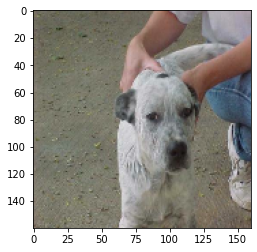

In [ ]:
# 3.9.3 Print Ist image in take(1)
for i , j in valid_ds.take(1):
  for k in tfds.as_numpy(i):
    print(k.shape)
    plt.imshow(k/255.0)
    break
  break

## Prefetching
Configure pre-fetching. For `prefetch()` API, see [here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch)<br>
prefetch() creates a Dataset that prefetches elements from this dataset.

### Configure the dataset for performance

In [ ]:
# 4.0 prefetch expt
dataset = tf.data.Dataset.range(3)
dataset = dataset.prefetch(2)
list(dataset.as_numpy_iterator())

[0, 1, 2]

In [ ]:
# 4.0.1 Get appropriate buffer size:
#       in train_ds to prefetch. If a buffer
#       is available, prefetching would be possible:

buf_size = tf.data.AUTOTUNE   # number of elements to be prefetched
train_ds = train_ds.prefetch(buffer_size = buf_size)
validation_dataset  = validation_dataset.prefetch(buffer_size = buf_size)
test_dataset = test_dataset.prefetch(buffer_size = buf_size)

## MobileNetV2 model weights
List of models available in tensorflow is [here](https://www.tensorflow.org/api_docs/python/tf/keras/applications).

In [ ]:
# 4.1 Create the base model from the pre-trained model MobileNet V2

IMG_SHAPE = image_size + (3,)   # (160,160,3)
# What about: f.keras.applications.mobilenet_v2.MobileNetV2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

type(base_model)  # keras.engine.functional.Functional

keras.engine.functional.Functional

In [ ]:
# 4.1.1
base_model.summary()

## Data augmentation function

In [ ]:
# 5.0 Data augmentation function:

data_augmentation = tf.keras.Sequential([
                                          tf.keras.layers.RandomFlip('horizontal'),
                                          tf.keras.layers.RandomRotation(0.2),
                                         ]
                                        )

In [ ]:
# 5.1
type(data_augmentation)

keras.engine.sequential.Sequential

Sequential() can also be called as below:

In [ ]:
# 5.2
data_augmentation = tf.keras.Sequential()

In [ ]:
# 5.3
data_augmentation.add(tf.keras.layers.RandomFlip('horizontal'))

In [ ]:
# 5.4
data_augmentation.add(tf.keras.layers.RandomRotation(0.2))

## Our model

In [ ]:
# 6.0 Classification model:
#      Each time you rerun the model, change seed
#       to some other number

# 6.1 Clear existing keras weights from model:
tf.keras.backend.clear_session()
seed = np.round(np.random.random() * 10000 ).astype('int')
tf.random.set_seed(seed)
#del md


# 6.2 The model
inputs = tf.keras.Input(shape = IMG_SHAPE )
x = data_augmentation(inputs)   # Note that it is a dequential model
# Rescaling is done by scale*inputs+offset.
# Rescaling(scale=4.0, offset=1.0) implies:
#   [0,255] range it would give 4*[0, 255]+1 = [1, 1021]
#   [0,255]                    1/127*[0,255] -1 = [-1,1]
x = tf.keras.layers.Rescaling(1./127.5, offset=-1)(x)  # Rescale (-1,1)
# Call the model on new inputs: (x):
# https://www.tensorflow.org/api_docs/python/tf/keras/Model#call
base = base_model(x , training = False)   # No training 
base = tf.keras.layers.Flatten()(base)
# Classifier
base = tf.keras.layers.Dense(256, activation = 'relu', name = "cde")(base)
type(base)
#base = tf.keras.layers.GlobalAveragePooling2D()(base)
#base = tf.keras.layers.Dropout(0.2)(base)
outputs = tf.keras.layers.Dense(1)(base)
md = tf.keras.Model(inputs = [inputs], outputs = [outputs])

keras.engine.keras_tensor.KerasTensor

In [ ]:
# 6.0.1 tf.keras.Sequential() behaves as layer in itself
#       Here is a modified code using two Sequential() objects.
#       Classification model:
#       Each time you rerun the model, change seed
#       to some other number

# 6.0.2 Clear existing keras weights from model:
tf.keras.backend.clear_session()
seed = np.round(np.random.random() * 10000 ).astype('int')
tf.random.set_seed(seed)
#del md


# 6.0.3 The model
inputs = tf.keras.Input(shape = IMG_SHAPE )
x = data_augmentation(inputs)   # Note that it is a dequential model
# Rescaling is done by scale*inputs+offset.
# Rescaling(scale=4.0, offset=1.0) implies:
#   [0,255] range it would give 4*[0, 255]+1 = [1, 1021]
#   [0,255]                    1/127*[0,255] -1 = [-1,1]
x = tf.keras.layers.Rescaling(1./127.5, offset=-1)(x)  # Rescale (-1,1)
# Call the model on new inputs: (x):
# https://www.tensorflow.org/api_docs/python/tf/keras/Model#call
base = base_model(x , training = False)   # No training 
base = tf.keras.layers.Flatten()(base)

# Classifier
base = tf.keras.Sequential(
                           [tf.keras.layers.Dense(256, activation = 'relu')],
                           name = "abc")(base)  # name of "abc" is that of Sequential() and NOT of Dense

type(base)
#base = tf.keras.layers.GlobalAveragePooling2D()(base)
#base = tf.keras.layers.Dropout(0.2)(base)
outputs = tf.keras.layers.Dense(1)(base)
md = tf.keras.Model(inputs = [inputs], outputs = [outputs])

keras.engine.keras_tensor.KerasTensor

In [ ]:
# 6.0.4
md.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 32000)             0         
                                                                 
 dense (Dense)               (None, 256)               8192256   
                                                             

See [tf.keras.losses.BinaryCrossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)<br>
Als [see](https://stackoverflow.com/questions/41455101/what-is-the-meaning-of-the-word-logits-in-tensorflow)

> <i>from_logits = True:</i><br>
>> Whether to interpret `y_pred` as a tensor of logit values. By default, we assume that `y_pred` contains probabilities (i.e., values in [0, 1]).

In [ ]:
# 6.3 Compile the mode:
#     This compilation gives very good results.
#     But see Note at the beginning.
# Adam: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam

base_learning_rate = 0.0001
md.compile(   optimizer=tf.keras.optimizers.Adam(
                                                learning_rate=base_learning_rate   # Default: 0.01
                                                ),
              loss=tf.keras.losses.BinaryCrossentropy(
                                                      from_logits=True  # Default: False
                                                     ),
              metrics=['accuracy']
           )

In [ ]:
# 6.4 Default learning rate of Adam gives BAD RESULTS:
#     This compilation does with default learning rate does not give good results: 

md.compile( 
            loss=tf.keras.losses.BinaryCrossentropy(
                                                      from_logits=True  # Default: False
                                                     ),
            optimizer = tf.keras.optimizers.experimental.Adam(),
            metrics = ["accuracy"]
           )

## Train model

In [ ]:
# 6.5 Train the model:

md.fit(train_ds,
       batch_size = batch_size,
       epochs = 10,
       validation_data = validation_dataset
       )

Epoch 1/10


63/63 [==============================] - 23s 211ms/step - loss: 0.2925 - accuracy: 0.8840 - val_loss: 0.1025 - val_accuracy: 0.9406
Epoch 2/10
63/63 [==============================] - 12s 184ms/step - loss: 0.1339 - accuracy: 0.9405 - val_loss: 0.0477 - val_accuracy: 0.9802
Epoch 3/10
63/63 [==============================] - 12s 184ms/step - loss: 0.1415 - accuracy: 0.9400 - val_loss: 0.1013 - val_accuracy: 0.9653
Epoch 4/10
63/63 [==============================] - 12s 185ms/step - loss: 0.1167 - accuracy: 0.9545 - val_loss: 0.0663 - val_accuracy: 0.9678
Epoch 5/10
63/63 [==============================] - 12s 184ms/step - loss: 0.0944 - accuracy: 0.9585 - val_loss: 0.0455 - val_accuracy: 0.9802
Epoch 6/10
63/63 [==============================] - 12s 184ms/step - loss: 0.0780 - accuracy: 0.9655 - val_loss: 0.0476 - val_accuracy: 0.9752
Epoch 7/10
63/63 [==============================] - 13s 200ms/step - loss: 0.0635 - accuracy: 0.9730 - val_loss: 0.0550 - val_accuracy: 0.9814
Epoch 8/10

## Initialise model
Does not appear to help

In [ ]:
# 7.0 Delete all model related variables:

del x , md, base, inputs, outputs

In [ ]:
# 7.1 Function to reinitailize model:

def reinitialize(model):
    for l in model.layers:
        if hasattr(l,"kernel_initializer"):
            l.kernel.assign(l.kernel_initializer(tf.shape(l.kernel)))
        if hasattr(l,"bias_initializer"):
            l.bias.assign(l.bias_initializer(tf.shape(l.bias)))
        if hasattr(l,"recurrent_initializer"):
            l.recurrent_kernel.assign(l.recurrent_initializer(tf.shape(l.recurrent_kernel)))

In [ ]:
# 7.2
reinitialize(md)

In [ ]:
########################## I am done ###################